In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import f1_score, auc, accuracy_score, recall_score, precision_score,\
confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
from google.colab import files
uploaded = files.upload()

Saving aps_failure.csv to aps_failure.csv


In [5]:
import io
train = pd.read_csv(io.BytesIO(uploaded['aps_failure.csv']))

In [6]:
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [7]:
train.shape

(60000, 171)

In [8]:
train.columns

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


In [10]:
#distribution of target class
train['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

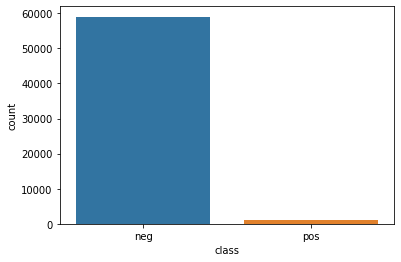

In [11]:
#Countplot
sns.countplot(x="class", data=train)
plt.show()

* From the above plot it can be observed that the given training data is highly imbalanced

In [12]:
# Replacing the na and nan values with np.NaN
train.replace(to_replace=['na','nan'],value = np.NaN,inplace=True)

In [13]:
# Number of missing values in each column
train.isnull().sum(axis = 0)

class         0
aa_000        0
ab_000    46329
ac_000     3335
ad_000    14861
          ...  
ee_007      671
ee_008      671
ee_009      671
ef_000     2724
eg_000     2723
Length: 171, dtype: int64

In [14]:
#top 15 column of missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = ((train.isnull().sum()/train.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,join='outer', keys=['Total Missing Count in the column', '% of Total Observations in the column'])
missing_data.index.name ='Feature'

missing_data.head(15)

,Total Missing Count in the column,% of Total Observations in the column
Feature,,
br_000,49264,82.106667
bq_000,48722,81.203333
bp_000,47740,79.566667
bo_000,46333,77.221667
ab_000,46329,77.215000
cr_000,46329,77.215000
bn_000,44009,73.348333
bm_000,39549,65.915000
bl_000,27277,45.461667


In [15]:
#filling missing value with 0
train = train.fillna(0)

In [16]:
train.isnull().sum()

class     0
aa_000    0
ab_000    0
ac_000    0
ad_000    0
         ..
ee_007    0
ee_008    0
ee_009    0
ef_000    0
eg_000    0
Length: 171, dtype: int64

In [17]:
train['class'].unique()

array(['neg', 'pos'], dtype=object)

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['class'] = le.fit_transform(train['class'])

In [19]:
train['class'].value_counts()

0    59000
1     1000
Name: class, dtype: int64

In [20]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
class,60000.0,0.016667,0.128020,0.0,0.0,0.0,0.0,1.0
aa_000,60000.0,59336.499567,145430.056532,0.0,834.0,30776.0,48668.0,2746564.0


In [21]:
train.describe(include='object').T

,count,unique,top,freq
ab_000,60000,30,0,46329
ac_000,60000,2062,0,8752
ad_000,60000,1887,0,14861
ae_000,60000,334,0,55543
af_000,60000,419,0,55476
...,...,...,...,...
ee_007,60000,30470,0,7898
ee_008,60000,24214,0,17280
ee_009,60000,9725,0,31863
ef_000,60000,29,0,57021


In [22]:
train.corr()

,class,aa_000
class,1.000000,0.536978
aa_000,0.536978,1.000000


### Box plot

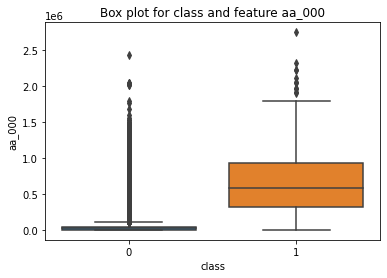

In [23]:
#Box Plot for aa_000 feature
sns.boxplot(x='class',y='aa_000', data=train).set_title("Box plot for class and feature aa_000")
plt.show()

* Shown plot only for aa_000 feature. Max, min values, outliers of both positive and negative class can be observed from above plot. Plot shows that negative class has more outliers and positive class is dominating when compared to negative.

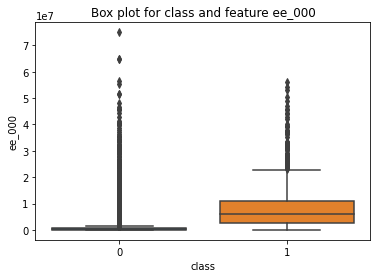

In [24]:
#Box Plot for histogram feature ee_000 
train_plot= train[['class', 'ee_000']]
# Removing rows with missing values
train_plot = train_plot.dropna(axis =0)
train_plot['ee_000'] = train_plot['ee_000'].astype(float)
sns.boxplot(x='class',y='ee_000', data=train_plot).set_title("Box plot for class and feature ee_000")
plt.show()

* Above plot shows box plot for histogram feature ee_000. Max, min values, outliers of both positive and negative class can be observed from above plot. Plot shows that negative class has more outliers and positive class is dominating when compared to negative.

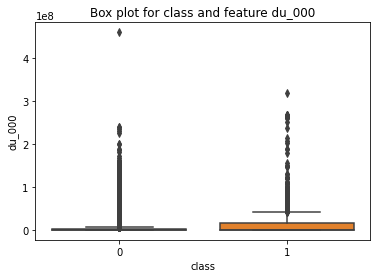

In [25]:
#Box Plot for du_000 feature
train_plot= train[['class', 'du_000']]
# Removing rows with missing values
train_plot = train_plot.dropna(axis =0)
train_plot['du_000'] = train_plot['du_000'].astype(float)
sns.boxplot(x='class',y='du_000', data=train_plot).set_title("Box plot for class and feature du_000")
plt.show()

* Above plot shows box plot for du_000 feature. Plot shows that there is no highly dominating class, both the classes have outliers.

### Histogram

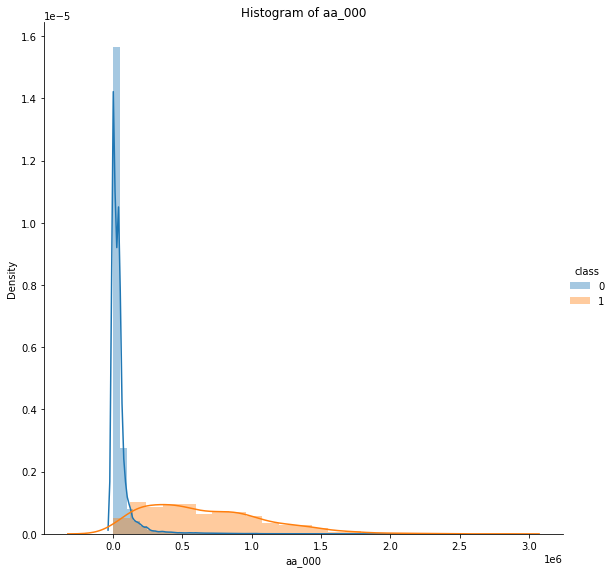

In [26]:
#Histogram of aa_000 feature
sns.FacetGrid(train, hue="class", size=8).map(sns.distplot, "aa_000").add_legend()
plt.title("Histogram of aa_000")
plt.show()

* Plot shows the distribution of positive and negative classes. Spread of positive class is more than negative, and values of positive class are below 0 as well. Positive class has long ending tail compared to negative class. Negative class has peak more than positive class.

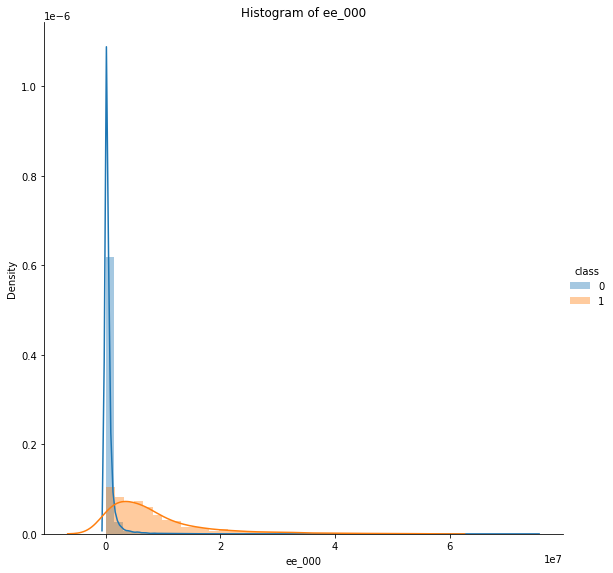

In [27]:
#Histogram of feature ee_000
sns.FacetGrid(train, hue="class", size=8).map(sns.distplot, "ee_000").add_legend()
plt.title("Histogram of ee_000")
plt.show()

* Plot shows the distribution of positive and negative classes. Spread of positive class is more than negative, and values of positive class are below 0 as well. Positive class has long ending tail compared to negative class. positive class has peak more than negative class.

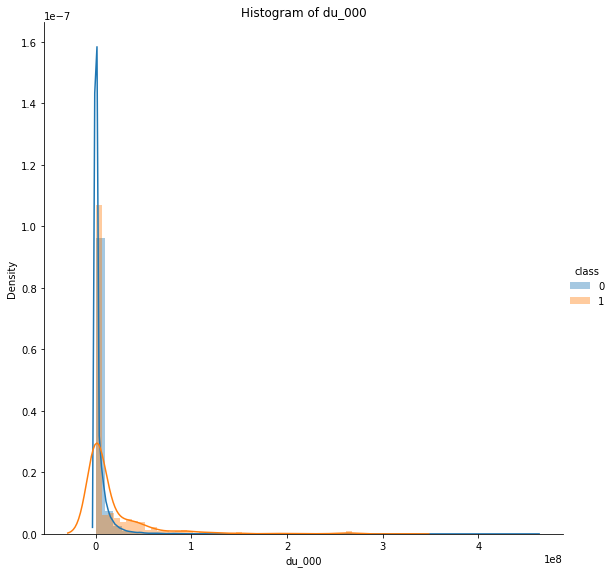

In [28]:
#Histogram of du_000 feature
sns.FacetGrid(train, hue="class", size=8).map(sns.distplot, "du_000").add_legend()
plt.title("Histogram of du_000")
plt.show()

* Plot shows the distribution of positive and negative classes. Spread of positive class is more than negative, and values of positive class are below 0 as well. Positive class has long ending tail compared to negative class. Positive class has peak more than negative class.

### Splitting dataset into train test

In [29]:
#Seperating label column from the data
x = train.drop('class', axis =1)
y= train['class']

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 0)

In [31]:
X_train.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
7927,34512,0,782,696,0,0,0,0,0,0,...,349726,167516,333892,227346,177892,116616,174578,4536,0,0
5212,29706,0,0,0,0,0,0,0,0,0,...,309050,181456,369078,250006,152304,66182,51940,46,0,0
28581,1990,0,2130706508,116,0,0,0,0,0,0,...,8734,4954,12340,62648,968,30,2,0,0,0
39089,77434,0,274,256,0,0,0,0,0,0,...,783338,471090,1288178,1126938,49024,560,124,0,0,0
52059,485496,0,0,0,0,0,0,0,30064,1124450,...,2495346,996552,1791582,1474516,2600914,11130022,210186,0,0,0


In [32]:
X_test.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
3048,61620,0,2130706432,1208,0,0,0,0,0,0,...,427716,218536,442570,425574,461636,293122,324408,12410,0,0
19563,551264,0,0,0,0,0,0,0,0,0,...,8838538,2117792,4444266,2836634,127750,10950,636,0,0,0
58303,946,2,50,50,0,0,0,0,0,13354,...,5888,2340,4684,4826,4642,16994,286,0,0,0
8870,256688,0,0,0,0,0,0,0,1262,1182610,...,5605900,1759242,2163574,999712,646000,1140880,21712,0,0,0
40228,61558,0,704,648,0,0,0,0,0,0,...,964318,458424,708748,397190,192778,93988,44716,6,0,0


In [33]:
#Standardize or feature scaling the dataset
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [34]:
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

## Model

### logistic regression

In [35]:
log_classifier=LogisticRegression()
log_classifier.fit(X_train_s, y_train)

LogisticRegression()

In [36]:
y_pred1 = log_classifier.predict(X_test_s)

In [37]:
accuracy_score(y_test, y_pred1)

0.9907777777777778

* Hyperparameter Tuning

In [38]:
parameters = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]

In [39]:
grid_search = GridSearchCV(estimator = log_classifier, param_grid = parameters,scoring = 'accuracy',cv = 5,verbose=0)

In [40]:
grid_search.fit(X_train_s, y_train)   

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 10, 100, 1000]}],
             scoring='accuracy')

In [41]:
grid_search.best_params_

{'C': 10}

In [42]:
log_classifier1=LogisticRegression(C=10 )
log_classifier1.fit(X_train_s,y_train)
y_pred_h = log_classifier1.predict(X_test_s)
accuracy_score(y_test, y_pred_h)

0.9909444444444444

In [43]:
#Auc-roc
ytest_pred = log_classifier1.predict_proba(X_test_s)
print('Logistic test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Logistic test roc-auc: 0.9656776733982966


In [44]:
print(classification_report(y_test, y_pred_h, labels=[1, 2, 3]))

              precision    recall  f1-score   support

           1       0.77      0.65      0.70       298
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

   micro avg       0.77      0.65      0.70       298
   macro avg       0.26      0.22      0.23       298
weighted avg       0.77      0.65      0.70       298



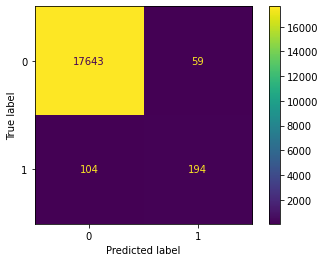

In [45]:
#confusion matrix
plot_confusion_matrix(log_classifier1, X_test_s, y_test)  
plt.show()

### SVC

In [79]:
svc_classifier = SVC(probability=True)
svc_classifier.fit(X_train_s, y_train)
y_pred2 = svc_classifier.predict(X_test_s)
accuracy_score(y_test, y_pred2)

0.987

In [81]:
#Auc-roc
y_pred_2 = svc_classifier.predict(X_test_s)
print('SVM test roc-auc: {}'.format(roc_auc_score(y_test, y_pred_2)))

SVM test roc-auc: 0.6238786198654988


In [47]:
print(classification_report(y_test, y_pred2, labels=[1, 2, 3]))

              precision    recall  f1-score   support

           1       0.88      0.25      0.39       298
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

   micro avg       0.88      0.25      0.39       298
   macro avg       0.29      0.08      0.13       298
weighted avg       0.88      0.25      0.39       298



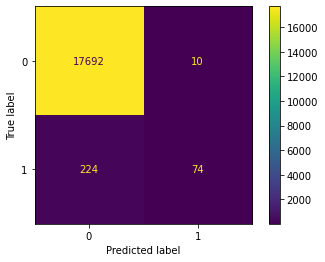

In [48]:
#confusion matrix
plot_confusion_matrix(svc_classifier, X_test_s, y_test)  
plt.show()

### Decision Tree

In [49]:
dt_classifier=DecisionTreeClassifier()
dt_classifier.fit(X_train,y_train)
y_pred3=dt_classifier.predict(X_test)
accuracy_score(y_test,y_pred3)


0.9892777777777778

In [50]:
dt_classifier1=DecisionTreeClassifier(criterion= 'entropy',max_depth= 5,min_samples_leaf= 3,min_samples_split= 5,splitter='random')
dt_classifier1.fit(X_train,y_train)
y_pred2_h = dt_classifier1.predict(X_test)
accuracy_score(y_test,y_pred2_h)

0.9867222222222222

In [56]:
#Auc-roc
y_pred3 = dt_classifier1.predict_proba(X_test)
print('DT test roc-auc: {}'.format(roc_auc_score(y_test, y_pred3[:,1])))

DT test roc-auc: 0.9718233218253881


In [52]:
print(classification_report(y_test, y_pred_h, labels=[1, 2, 3]))

              precision    recall  f1-score   support

           1       0.77      0.65      0.70       298
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

   micro avg       0.77      0.65      0.70       298
   macro avg       0.26      0.22      0.23       298
weighted avg       0.77      0.65      0.70       298



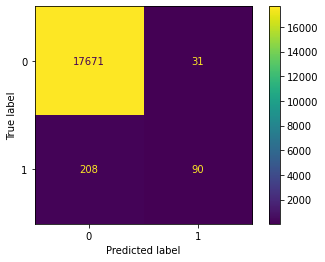

In [55]:
#confusion matrix
plot_confusion_matrix(dt_classifier1, X_test, y_test)  
plt.show()

### Random Forest

In [57]:
rf_classifier = RandomForestClassifier(max_depth=2, random_state=0)
rf_classifier.fit(X_train,y_train)
y_pred4  = rf_classifier.predict(X_test)
accuracy_score(y_test, y_pred1)

0.9907777777777778

In [75]:
#Auc-roc
y_pred_4 = rf_classifier.predict_proba(X_test)
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, y_pred_4[:,1])))

RF test roc-auc: 0.9641354558200301


In [59]:
print(classification_report(y_test, y_pred4, labels=[1, 2, 3]))

              precision    recall  f1-score   support

           1       0.89      0.18      0.31       298
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

   micro avg       0.89      0.18      0.31       298
   macro avg       0.30      0.06      0.10       298
weighted avg       0.89      0.18      0.31       298



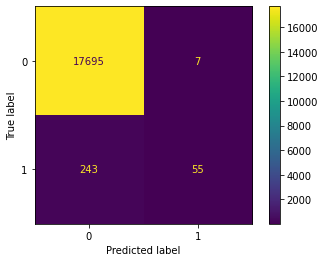

In [60]:
#confusion matrix
plot_confusion_matrix(rf_classifier, X_test, y_test)  
plt.show()

### Adaboost

In [61]:
ab_classifier = AdaBoostClassifier()
ab_classifier.fit(X_train,y_train)
y_pred5 = ab_classifier.predict(X_test)
accuracy_score(y_test,y_pred5)

0.9901666666666666

In [74]:
#Auc-roc
y_pred_5 = ab_classifier.predict_proba(X_test)
print('AdaBoost test roc-auc: {}'.format(roc_auc_score(y_test, y_pred_5[:,1])))

AdaBoost test roc-auc: 0.9821018972565191


In [63]:
print(classification_report(y_test, y_pred5, labels=[1, 2, 3]))

              precision    recall  f1-score   support

           1       0.74      0.62      0.68       298
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

   micro avg       0.74      0.62      0.68       298
   macro avg       0.25      0.21      0.23       298
weighted avg       0.74      0.62      0.68       298



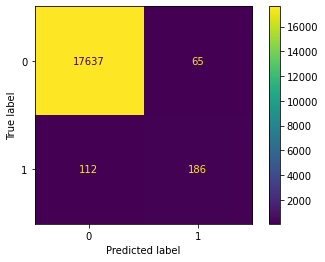

In [64]:
#confusion matrix
plot_confusion_matrix(ab_classifier, X_test, y_test)  
plt.show()

### Gradient Boosting

In [65]:
model_gb = GradientBoostingClassifier()
model_gb.fit(X_train,y_train)
y_pred6 = model_gb.predict(X_test)
accuracy_score(y_test,y_pred6)

0.9919444444444444

In [99]:
grid_param = {
    "learning_rate":[0.01,0.001,0.1],
    "n_estimators" : [90,100,115],
    'max_depth' : range(2,20,1),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split': range(2,10,1),
    'max_features' : ['auto','log2']
}

In [ ]:
grid_searh=GridSearchCV(estimator=model_gb,param_grid=grid_param,cv=3,verbose=1)
grid_searh.fit(X_train,y_train)

[17:04:02] ======== Monitor: Learner ========
[17:04:02] ======== Monitor: Learner ========
[17:04:02] ======== Monitor: Learner ========
Fitting 3 folds for each of 23328 candidates, totalling 69984 fits


In [70]:
#Auc-roc
y_pred_6 = ab_classifier.predict_proba(X_test)
print('GB test roc-auc: {}'.format(roc_auc_score(y_test, y_pred_6[:,1])))

GB test roc-auc: 0.9821018972565191


In [67]:
print(classification_report(y_test, y_pred6, labels=[1, 2, 3]))

              precision    recall  f1-score   support

           1       0.83      0.65      0.73       298
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

   micro avg       0.83      0.65      0.73       298
   macro avg       0.28      0.22      0.24       298
weighted avg       0.83      0.65      0.73       298



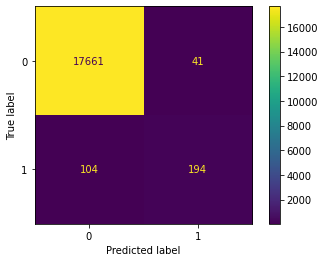

In [68]:
#confusion matrix
plot_confusion_matrix(model_gb, X_test, y_test)  
plt.show()

### XGBoost

In [72]:
X_train = X_train.apply(pd.to_numeric)
X_test = X_test.apply(pd.to_numeric)

In [73]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train,y_train)
y_pred7 = model_xgb.predict(X_test)
accuracy_score(y_test,y_pred7)

0.9924444444444445

In [76]:
#Auc-roc
y_pred_7 = ab_classifier.predict_proba(X_test)
print('XGB test roc-auc: {}'.format(roc_auc_score(y_test, y_pred_7[:,1])))

XGB test roc-auc: 0.9821018972565191


In [77]:
print(classification_report(y_test, y_pred7, labels=[1, 2, 3]))

              precision    recall  f1-score   support

           1       0.87      0.64      0.74       298
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

   micro avg       0.87      0.64      0.74       298
   macro avg       0.29      0.21      0.25       298
weighted avg       0.87      0.64      0.74       298



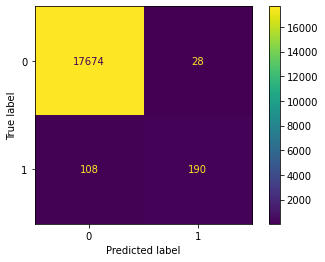

In [78]:
#confusion matrix
plot_confusion_matrix(model_xgb, X_test, y_test)  
plt.show()